In [4]:
from __future__ import division, print_function, absolute_import
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import warnings
import sys
from PIL import Image
from timeit import time

# set config to initialize cudnn
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction import features

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.tools.plot_utils import draw_one_box as draw_box
from yolo3_deepsort.deep_sort.detection import Detection as ddet

In [5]:
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
            classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
            weights_only = True,
            score = 0.3,
            iou = 0.3)
# video_handle = 'yolo3_deepsort/model_data/Crossroad.mp4'

yolo3_deepsort/model_data/trained_weights_coco.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


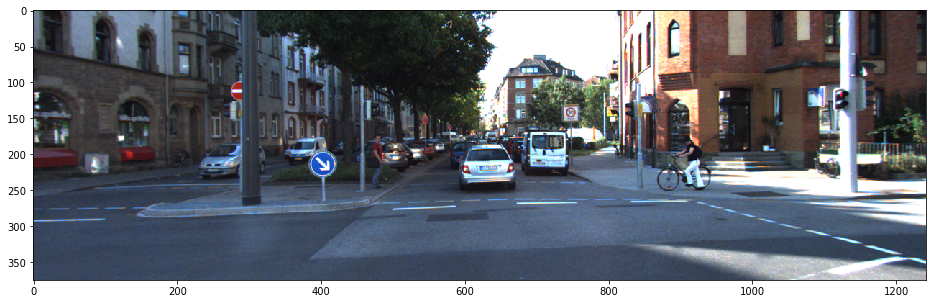

In [7]:
img_name = "000150_10.png"
ima_path = "/media/yxhuang/database"
img1_path = ima_path + "/KITTI_stereo/data_scene_flow/training/image_2/"+img_name
img2_path = ima_path + "/KITTI_stereo/data_scene_flow/training/image_3/"+img_name
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

img_pil1 = Image.fromarray(img1.copy()[...,::-1])
img_pil2 = Image.fromarray(img2.copy()[...,::-1])

plt.figure(figsize=(16,9))
plt.imshow(img1[...,::-1])

# Detection

In [9]:
tio = time.time()
boxes,classes,scores = yolo.detect_image(img_pil1)# detect
print('it takes %f s'%(time.time()-tio))

it takes 1.972789 s


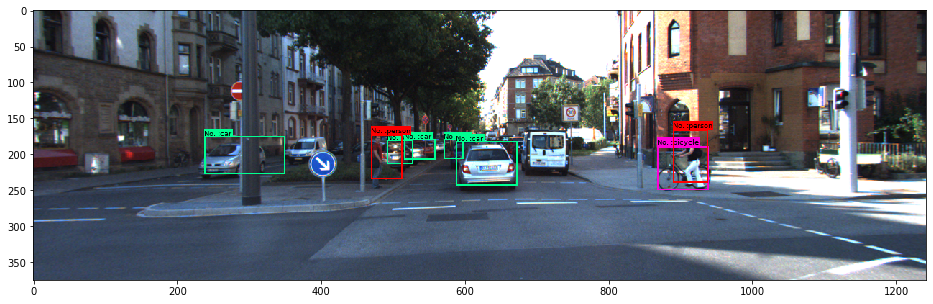

In [10]:
for bbox,cat in zip(boxes,classes):
    color = yolo.colors[yolo.class_names.index(cat)]
    bbox = np.array(bbox)
    bbox[2:] = bbox[:2] + bbox[2:]#tlwh to tlbr
    img_draw1 = draw_box(img_pil1,bbox,' ',cat,color,fontsize=10)

plt.figure(figsize=(16,12))
img_show = np.asarray(img_draw1)
plt.imshow(img_show)

# Found Features in Whole Photo

In [11]:
# find correspondence points
pts1, pts2 = features.find_correspondence_points(img1, img2,feature='SURF')
points1 = processor.cart2hom(pts1)
points2 = processor.cart2hom(pts2)

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [12]:
plt.figure(figsize=(16,12))
plt.plot(points1[0],points1[1],'ro',markerfacecolor = 'none', markersize=2)
plt.imshow(img_show)

NameError: name 'points1' is not defined

<Figure size 1152x864 with 0 Axes>

# Find Feature Point in the BBoxes

In [13]:
for i in range(len(boxes)):
    l,t,w,h = boxes[i]
    r = l + w;b = t + h
    patch_img = img1[t:b,l:r,:]

    fea = cv2.xfeatures2d.SURF_create()
    kp1, des1 = fea.detectAndCompute(cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY), None)
    print("has %d key points"%(len(kp1)))

    plt.figure(figsize=(10,6))
    patch_show = patch_img.copy()
#     patch_show = cv2.drawKeypoints(patch_img,kp1,patch_show)#draw key points
    # cv2.imshow('box'+str(i),patch_show[...,::-1])
    plt.imshow(patch_show[...,::-1])

# cv2.waitKey(0)
# cv2.destroyAllWindows()

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

# Nonstrict search range

it takes 0.065686 s
(top,bottom,left,right): 166 239 866 914


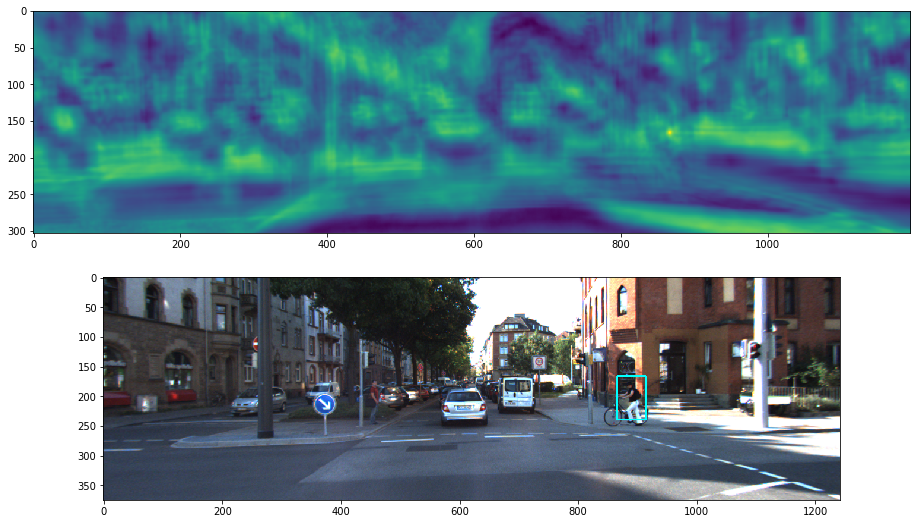

In [14]:
# get template
l,t,w,h = boxes[-1]
r = l + w;b = t + h
template = img1[t:b,l:r,:]

search_patch = img2
tio = time.time()
res = cv2.matchTemplate(search_patch,template,cv2.TM_CCOEFF_NORMED)
print('it takes %f s'%(time.time()-tio))
min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(res)

# the matched patch's location
left_top = max_loc
right_bottom = (left_top[0]+w, left_top[1]+h)

img = img2.copy()
cv2.rectangle(img,left_top,right_bottom,(255,255,0),2)
print("(top,bottom,left,right):",left_top[1],right_bottom[1],left_top[0],right_bottom[0])

plt.figure(figsize=(16,9))
plt.subplot(211);plt.imshow(res)
plt.subplot(212);plt.imshow(img[...,::-1])

# Strict Search Range

In [15]:
def get_patch_by_box(img,box):
    '''get a patch in an image by the bouding box
    parameters:
    ==========
    img1: image in array format
    box: bouding box(x,y,w,h)
    
    returns:
    =======
    template: an array
    '''
    l,t,w,h = box
    r = l + w;b = t + h
    template = img1[t:b,l:r,:]
    return template

In [16]:
def match_stricted_area(img1,img2,box):
    '''matching template around the box in another image
    parameters:
    ==========
    img1: image has template
    img2: searched image
    box: bouding box(x,y,w,h)
    
    returns:
    =======
    res: the result of matching template
    search_patch: the search range in the image
    box_matched: left,top,right,bottom,the coordination of the searched patch
    '''
    
    l,t,w,h = box
    r = l + w;b = t + h
    template = get_patch_by_box(img1,box)
    
    # strict search range
    ts,bs,rs,ls = np.array([t,b,r,l],dtype='int32') + np.array([-h/2,h/2.,w/2.,-w/2.],dtype='int32')
    # ts,bs,rs,ls = np.array([t,b,r,l],dtype='int32') 
    # over screen
    ts = max(0,ts);ls = max(0,ls)
    bs = min(img2.shape[0],bs); rs = min(img2.shape[1],rs)
    
    search_patch = img2[ts:bs,ls:rs,:]#search around the template
    res = cv2.matchTemplate(search_patch,template,cv2.TM_CCOEFF)
    min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(res)
    
    # the matched patch's location
    l_matched = max_loc[0]+ls
    t_matched = max_loc[1]+ts
    r_matched = min(l_matched+w,img2.shape[1])
    b_matched = min(t_matched+h,img2.shape[0])
    
    box_matched = (l_matched,t_matched,r_matched,b_matched)
    return res,search_patch,box_matched

it takes 0.010667 s
(top,bottom,left,right): 166 239 866 914


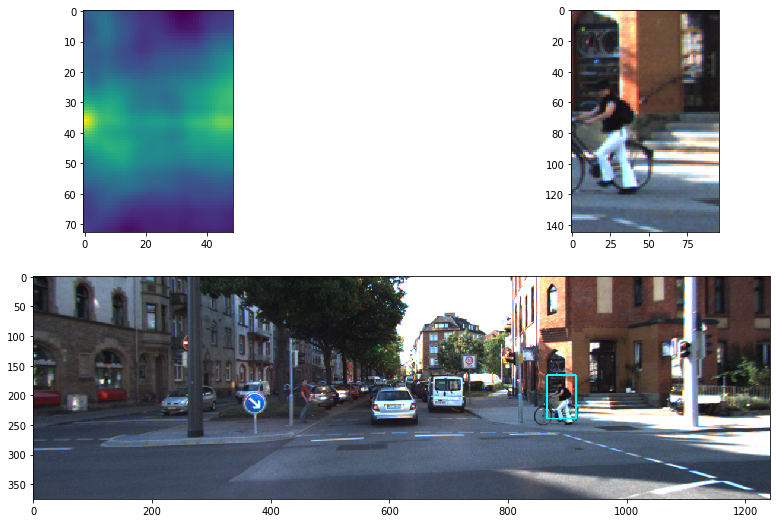

In [17]:
# get template
box = boxes[-1]
template = get_patch_by_box(img1,box)
tio = time.time()
res,search_patch,box_matched = match_stricted_area(img1,img2,box)#match template
print('it takes %f s'%(time.time()-tio))
l,t,r,b = box_matched

img = img2.copy()
cv2.rectangle(img,(l,t),(r,b),(255,255,0),2)
print("(top,bottom,left,right):",t,b,l,r)

plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((2,2),(0,0),colspan = 1,rowspan = 1);ax1.imshow(res)
ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1,rowspan = 1);ax2.imshow(search_patch[...,::-1])
ax3 = plt.subplot2grid((2,2),(1,0),colspan = 2,rowspan = 1);ax3.imshow(img[...,::-1])

# Macth all the boxes

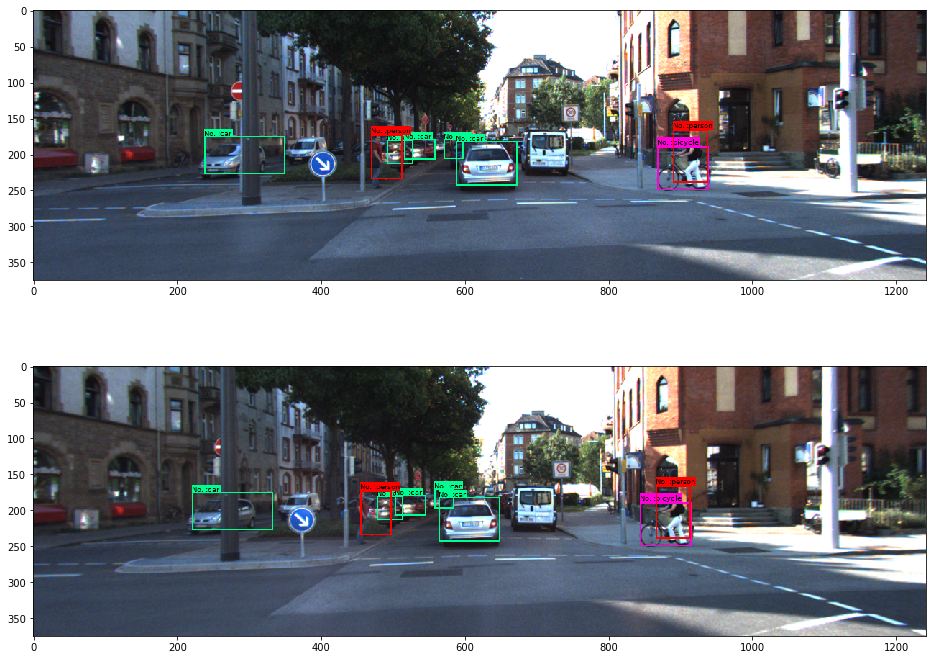

In [18]:
boxes_matched = []#tlbr
for box in boxes:
    _,_,box_matched = match_stricted_area(img1,img2,box)#match template
    boxes_matched.append(box_matched)

for box,box_m,cat in zip(boxes,boxes_matched,classes):
    color = yolo.colors[yolo.class_names.index(cat)]
    box = np.array(box);box_m = np.array(box_m);
    
    box[2:] = box[:2] + box[2:]#tlwh to tlbr
    img_draw1 = draw_box(img_pil1,box,' ',cat,color,fontsize=10)
    img_draw2 = draw_box(img_pil2,box_m,' ',cat,color,fontsize=10)

img1_show = np.asarray(img_draw1)
img2_show = np.asarray(img_draw2)
plt.figure(figsize=(16,12))
plt.subplot(211);plt.imshow(img1_show)
# plt.subplot(212);plt.imshow(img2_show)
plt.subplot(212);plt.imshow(np.asarray(img_pil2))

# Get 3D points

In [33]:
def read_calib(calib_path,img_name):
    '''Read calibration file by image's name
    Parameters:
    ==========
    calib_path: the path of the directory saving calibration files
    img_name: image's name
    
    return:
    P2,P3: the camera matrix of two image
    '''
    calib_name = calib_path + img_name.split('.')[0][:6] + ".txt"
    with open(calib_name) as f:
        while True:
            line = f.readline()
            if not line:
                break
            para_name,data = line.strip().split(':',1)
            if para_name == 'P_rect_02':
                P2_array = data.strip().split(' ',11)
                P2 = np.array(P2_array,dtype = 'float').reshape(3,4)
            if para_name == 'P_rect_03':
                P3_array = data.strip().split(' ',11)
                P3 = np.array(P3_array,dtype = 'float').reshape(3,4)
                
    return P2,P3

In [34]:
# use the center of boxes stand for object's location
pts2D_1 = np.ones((3,len(boxes)),dtype='float')
pts2D_2 = np.ones((3,len(boxes)),dtype='float')

for i in range(len(boxes)):
    pts2D_1[0,i] = boxes[i][0]+boxes[i][2]/2
    pts2D_1[1,i] = boxes[i][1]+boxes[i][3]/2
    pts2D_2[0,i] = (boxes_matched[i][0]+boxes_matched[i][2])/2
    pts2D_2[1,i] = (boxes_matched[i][1]+boxes_matched[i][3])/2

In [35]:
# read calibration information
calib_path = "G:\\KITTI_stereo\\data_scene_flow\\training\\calib_cam_to_cam\\"
calib_name = calib_path + img_name.split('.')[0][:6] + ".txt"
P1,P2 = read_calib(calib_path,img_name)
# linear triangulation
pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P1,P2)

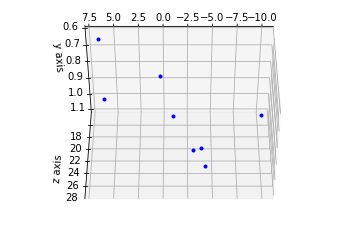

In [36]:
# X朝前，Y朝右，Z朝上
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pts3D[0], pts3D[1], pts3D[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()

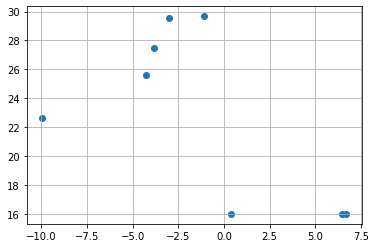

In [39]:
plt.grid()
plt.scatter(pts3D[0],pts3D[2])